In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score, log_loss
from scipy import optimize
from keras import losses
from keras import backend as K
import tensorflow as tf
from sklearn import neural_network

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import *
from keras.wrappers.scikit_learn import KerasClassifier
import keras
from keras import losses


%matplotlib notebook

Using TensorFlow backend.


# Preprocessing

In [2]:
data = pd.read_csv('leaf.csv', header=None)
data.drop([1],inplace=True,axis=1)
X = data.values[:,1:]
Y_first = data.values[:,0]
Y = []
out = np.zeros(shape=[36])
for i in range(np.shape(Y_first)[0]):
    out[int(Y_first[i])-1]=1
    Y.append(out)
    out = np.zeros(shape=[36])
Y = np.array(Y)
# min_max_scaler = preprocessing.MinMaxScaler()
# X_scaled = min_max_scaler.fit_transform(X)
# df_normalized = pd.DataFrame(X_scaled)

r,c = np.shape(X)

total_samples = list(np.arange(0,r,1))
test_samples = random.sample(total_samples,int(np.round(len(total_samples)*0.2)))
train_samples = list(set(total_samples) - set(test_samples))

# Splitting Data

In [151]:
trainX = X[train_samples]
trainX_scaled = (trainX-np.min(trainX))/(np.max(trainX)-np.min(trainX))
trainY = Y[train_samples]
trainY_comp = Y_first[train_samples]

testX = X[test_samples]
testX_scaled = (testX-np.min(testX))/(np.max(testX)-np.min(testX))
testY = Y[test_samples]
testY_comp = Y_first[test_samples]
print(len(trainX[0]))
print(len(trainY[0]))

c = list(range(0, len(trainX)))
val_ind = random.sample(c, 82)
train_ind = list(set(c)-set(val_ind))

trainX_val = trainX[val_ind]
trainY_val = trainY[val_ind]
trainY_comp_val = trainY_comp[val_ind]

trainX = trainX[train_ind]
trainY = trainY[train_ind]
trainY_comp = trainY_comp[train_ind]

14
36


In [188]:
np.save('trainX.npy',trainX)
np.save('trainY.npy',trainY)
np.save('trainY_comp.npy',trainY_comp)

np.save('testX.npy',testX)
np.save('testY.npy',testY)
np.save('testY_comp.npy',testY_comp)

np.save('trainX_val.npy',trainX_val)
np.save('trainY_val.npy',trainY_val)
np.save('trainY_comp_val.npy',trainY_comp_val)

In [153]:
def logloss(true_label, predicted, eps=1e-15):
  p = np.clip(predicted, eps, 1 - eps)
  if true_label == 1:
    return -np.log(p)
  else:
    return 0

In [154]:
def de(fobj, bounds=[-2,2], mut=0.8, crossp=0.7, popsize=50, its=1000):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in pop_denorm])
    fitness_val = np.asarray([nn_objective_val(ind) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best_idx_val = np.argmin(fitness_val)
    best = pop_denorm[best_idx]
    best_val = pop_denorm[best_idx_val]
    f_all_train = []
    f_all_val = []
    for i in range(its):
        if i == 0:
            best_all = best
            best_val_all = best_val
            fitness_best_all = fitness[best_idx]
            fitness_best_all_val = fitness_val[best_idx_val]
            print(fitness_best_all_val)
        for j in range(popsize):
            f_all_train.append(np.mean(fitness))
            f_all_val.append(np.mean(fitness_val))
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), 0, 1)
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            f_val = nn_objective_val(trial_denorm)
            if  f_val < fitness_best_all_val:
                best_val_all = trial_denorm
                fitness_best_all_val = f_val
                print(nn_objective_val(best_val_all))
                print(fitness_best_all_val)
            if f < fitness[j]:
                fitness[j] = f
                fitness_val[j] = f_val
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
                if fitness[best_idx]<fitness_best_all:
                    best_all = best
                    fitness_best_all = fitness[best_idx]
#         val_fit_idx = np.argmin(fitness_val)
#         val_fit_c = fitness_val[val_fit_idx]
#         if  val_fit_c < fitness_best_all_val:
#             best_val = pop[val_fit_idx]
                
    return best_all, fitness_best_all, fitness_best_all_val, f_all_train, f_all_val, best_val_all

#  Neural Network

In [155]:
def nn_objective_train(x):
    num_inputs = 14
    num_outputs = 36
    hidden_layer_neurons = 405
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]
    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
    l1 = np.maximum(np.dot(trainX, w1)+b1, 0)
    x_i = np.dot(l1, w2)+b2
    l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
    l2_act = np.argmax(l2,axis=1)+1
    output = np.clip(l2, 1e-15, 1. - 1e-15)
    er= -np.sum(trainY* np.log(l2))
    return er

def nn_objective_val(x):
    num_inputs = 14
    num_outputs = 36
    hidden_layer_neurons = 405
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]
    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
    l1 = np.maximum(np.dot(trainX_val, w1)+b1, 0)
    x_i = np.dot(l1, w2)+b2
    l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
    l2_act = np.argmax(l2,axis=1)+1
    output = np.clip(l2, 1e-15, 1. - 1e-15)
    er= -np.sum(trainY_val * np.log(l2))
    return er

# Mutation 

In [190]:
num_inputs = 14
num_outputs = 36

hidden_layer_neurons = 405

weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
bias_all = hidden_layer_neurons+num_outputs

tw = weights_all+bias_all 
w0 = 2*np.random.random((1,tw))-2

b = [(-1,1)]
for i in range(len(w0[0])-1):
    b.append((-1,1))

#mut_all = np.arange(0.1,1,0.1)
mut_all = np.array([0.0,0.2,0.4,0.6,0.8])
crossp_all = np.array([0.4,0.6,0.8])
popsize_all = np.array([50,100,200])
r_all = []
v_l = []
t_l = []
res_all = []
for i in range(len(mut_all)):
    print(i)
    res1 = list(de(nn_objective_train,b,mut=mut_all[i], crossp=0.8, popsize=50, its=250))
    r_all.append(np.array([mut_all[i],res1[1]]))
    t_l.append(res1[1])
    v_l.append(res1[2])
    res_all.append(res1)
#res = optimize.basinhopping(nn_objective, w0[0], niter=1000,disp=True)
# res1 = list(de(nn_objective,b,mut=0.0, crossp=0.9, popsize=50, its=1000))


0
1581.68712304
1559.79942772
1559.79942772
1519.02617587
1519.02617587
1508.53800209
1508.53800209
1421.49596157
1421.49596157
1415.18240757
1415.18240757
1361.65988681
1361.65988681
1318.13483517
1318.13483517
1315.07822095
1315.07822095
1312.32616188
1312.32616188
1238.96448853
1238.96448853
1175.79416741
1175.79416741
1158.40816733
1158.40816733
1099.90317522
1099.90317522
1078.97097827
1078.97097827
1039.65103155
1039.65103155
931.351421628
931.351421628
928.759141283
928.759141283
878.897667286
878.897667286
820.872069552
820.872069552
806.05451837
806.05451837
1
1739.14674004
1614.46551559
1614.46551559
1537.13539242
1537.13539242
1467.7299683
1467.7299683
1438.76373059
1438.76373059
1384.28539455
1384.28539455
1275.71195103
1275.71195103
1169.65322176
1169.65322176
1110.01008562
1110.01008562
1031.2674883
1031.2674883
988.30620311
988.30620311
951.337891597
951.337891597
917.516882752
917.516882752
894.38537617
894.38537617
865.210664034
865.210664034
786.148385051
786.14838505

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply


1967.5299211
1967.5299211
1821.29181984
1821.29181984
1813.54031225
1813.54031225
1743.29240654
1743.29240654
1741.57852053
1741.57852053
1730.03415243
1730.03415243
1553.66211266
1553.66211266
1522.87584831
1522.87584831
1250.32114322
1250.32114322
4
2125.11715372


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


2082.50608493
2082.50608493
1646.74900485
1646.74900485


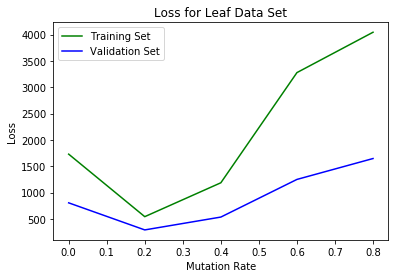

[1729.850946403496, 543.6574503771833, 1186.8021260753017, 3277.1880560610662, 4043.0389453968182]
[806.05451836957695, 292.1945745527903, 536.01859462945117, 1250.3211432173832, 1646.7490048459395]


In [192]:
plt.plot(mut_all,np.array(t_l),'g',label='Training Set')
plt.plot(mut_all,np.array(v_l),'b',label='Validation Set')
plt.xlabel('Mutation Rate')
plt.ylabel('Loss')
plt.title('Loss for Leaf Data Set')

plt.legend()
plt.show()
print(t_l)
print(v_l)

# Crossover 

In [158]:
num_inputs = 14
num_outputs = 36

hidden_layer_neurons = 405

weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
bias_all = hidden_layer_neurons+num_outputs

tw = weights_all+bias_all 
w0 = 2*np.random.random((1,tw))-2

b = [(-1,1)]
for i in range(len(w0[0])-1):
    b.append((-1,1))

#mut_all = np.arange(0.1,1,0.1)
mut_all = np.array([0.0,0.2,0.4,0.6,0.8])
crossp_all = np.array([0.0, 0.2, 0.4,0.6,0.8])
popsize_all = np.array([50,100,200])
r_all_2 = []
v_l_2 = []
t_l_2 = []
res_all_2 = []
for i in range(len(crossp_all)):
    print(i)
    res2 = list(de(nn_objective_train,b,mut=0.4, crossp=crossp_all[i], popsize=50, its=500))
    r_all_2.append(np.array([crossp_all[i],res2[1]]))
    t_l_2.append(res2[1])
    v_l_2.append(res2[2])
    res_all_2.append(res2)
#res = optimize.basinhopping(nn_objective, w0[0], niter=1000,disp=True)
# res1 = list(de(nn_objective,b,mut=0.0, crossp=0.9, popsize=50, its=1000))


0
1747.17882142
1739.15526298
1739.15526298
1738.11718435
1738.11718435
1738.01118932
1738.01118932
1737.92770305
1737.92770305
1737.92770305
1737.92770305
1737.92770305
1737.92770305
1735.47872769
1735.47872769
1735.47872769
1735.47872769
1732.75424967
1732.75424967
1732.53678174
1732.53678174
1732.23694005
1732.23694005
1732.23693997
1732.23693997
1727.83280365
1727.83280365
1727.8085718
1727.8085718
1727.40256763
1727.40256763
1727.40256763
1727.40256763
1727.14361506
1727.14361506
1715.90736391
1715.90736391
1715.82722472
1715.82722472
1713.12025024
1713.12025024
1712.93085009
1712.93085009
1709.41528858
1709.41528858
1709.39845574
1709.39845574
1706.98994592
1706.98994592
1705.65809673
1705.65809673
1696.08381565
1696.08381565
1694.23144362
1694.23144362
1693.33767268
1693.33767268
1574.48583375
1574.48583375
1572.05203917
1572.05203917
1558.4186671
1558.4186671
1555.69748511
1555.69748511
1555.69279824
1555.69279824
1552.31139814
1552.31139814
1552.3111188
1552.3111188
1550.22558

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply


1425.42980446
1425.42980446
1292.27679286
1292.27679286
4
2170.77120552
1980.00263813
1980.00263813
1877.13029923
1877.13029923
1818.39829279
1818.39829279
1746.87963003
1746.87963003
1545.8737208
1545.8737208
1456.23689549
1456.23689549
1352.84852316
1352.84852316
1110.82733274
1110.82733274
993.724317867
993.724317867
983.938168023
983.938168023
983.855385005
983.855385005
964.857059614
964.857059614
963.614893814
963.614893814
951.951302787
951.951302787
940.427066466
940.427066466
906.58452144
906.58452144
883.698553638
883.698553638
868.704806575
868.704806575
866.457582453
866.457582453
813.762644831
813.762644831
779.303051731
779.303051731
730.350623708
730.350623708
707.662274642
707.662274642
687.209026383
687.209026383
648.322423181
648.322423181
625.954230338
625.954230338
585.380320172
585.380320172
529.437001896
529.437001896
486.913249912
486.913249912
477.132709236
477.132709236
472.029456563
472.029456563
454.929135339
454.929135339
423.174684149
423.174684149
402.2592

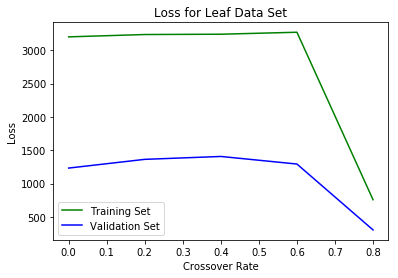

[3200.1658621432998, 3235.2283498030974, 3239.7984934362125, 3269.4590567428536, 756.73660265773538]
[1231.6408808002475, 1362.5192897292447, 1405.9196008084336, 1292.2767928647254, 303.81409994897837]


In [159]:
plt.plot(crossp_all,t_l_2,'g',label='Training Set')
plt.plot(crossp_all,v_l_2,'b',label='Validation Set')
plt.xlabel('Crossover Rate')
plt.ylabel('Loss')
plt.title('Loss for Leaf Data Set')

plt.legend()
plt.show()
print(t_l_2)
print(v_l_2)

# Pop Size

In [160]:
num_inputs = 14
num_outputs = 36

hidden_layer_neurons = 405

weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
bias_all = hidden_layer_neurons+num_outputs

tw = weights_all+bias_all 
w0 = 2*np.random.random((1,tw))-2

b = [(-1,1)]
for i in range(len(w0[0])-1):
    b.append((-1,1))

#mut_all = np.arange(0.1,1,0.1)
#mut_all = np.array([0.0,0.2,0.4,0.6,0.8])
#crossp_all = np.array([0.0, 0.2, 0.4,0.6,0.8])
popsize_all = np.array([50,100,150])
r_all_3 = []
v_l_3 = []
t_l_3 = []
res_all_3 = []
for i in range(len(popsize_all)):
    print(i)
    res3 = list(de(nn_objective_train,b,mut=0.4, crossp=0.8, popsize=popsize_all[i], its=500))
    r_all_3.append(np.array([crossp_all[i],res3[1]]))
    t_l_3.append(res3[1])
    v_l_3.append(res3[2])
    res_all_3.append(res3)
#res = optimize.basinhopping(nn_objective, w0[0], niter=1000,disp=True)
# res1 = list(de(nn_objective,b,mut=0.0, crossp=0.9, popsize=50, its=1000))


0
2062.2529071
1990.05320427
1990.05320427
1828.12499372
1828.12499372
1787.21210362
1787.21210362
1345.63237913
1345.63237913
1123.03431939
1123.03431939
1087.7253546
1087.7253546
1064.11102204
1064.11102204
989.242566618
989.242566618
974.029650023
974.029650023
931.733743943
931.733743943
931.148061768
931.148061768
908.63717154
908.63717154
856.849919589
856.849919589
849.739420021
849.739420021
848.259519321
848.259519321
783.001497122
783.001497122
748.428517673
748.428517673
707.73997136
707.73997136
698.159368913
698.159368913
677.812974889
677.812974889
605.48607582
605.48607582
579.608135434
579.608135434
545.747181452
545.747181452
468.410341228
468.410341228
467.770295148
467.770295148
458.365434407
458.365434407
439.021489163
439.021489163
438.129183232
438.129183232
408.182184323
408.182184323
383.22400418
383.22400418
365.803085102
365.803085102
360.674987665
360.674987665
349.589800084
349.589800084
341.30956165
341.30956165
333.795392105
333.795392105
1
1863.28537969
1

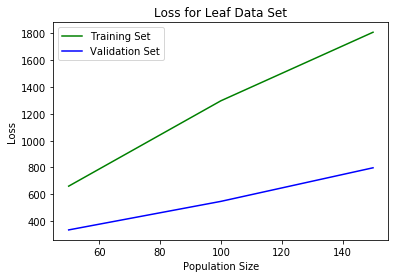

[660.43099568357388, 1297.5474889906329, 1809.3248830872137]
[333.79539210531851, 546.79511708681412, 797.5094914905543]


In [189]:
plt.plot(popsize_all,t_l_3,'g',label='Training Set')
plt.plot(popsize_all,v_l_3,'b',label='Validation Set')
plt.xlabel('Population Size')
plt.ylabel('Loss')
plt.title('Loss for Leaf Data Set')

plt.legend()
plt.show()
print(t_l_3)
print(v_l_3)

# Grid Seach

In [162]:
num_inputs = 14
num_outputs = 36

hidden_layer_neurons = 405

weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
bias_all = hidden_layer_neurons+num_outputs

tw = weights_all+bias_all 
w0 = 2*np.random.random((1,tw))-2

b = [(-1,1)]
for i in range(len(w0[0])-1):
    b.append((-1,1))

mut_all = np.array([0.0,0.2,0.4])
crossp_all = np.array([0.4,0.6,0.8])
popsize_all = np.array([50,100,150])
r_all = []
for i in range(len(mut_all)):
    print(i)
    for j in range(len(crossp_all)):
        for k in range(len(popsize_all)):
            res = list(de(nn_objective_train,b,mut=mut_all[i], crossp=crossp_all[j], popsize=popsize_all[k], its=500))
            r_all.append(np.array([mut_all[i],crossp_all[j],popsize_all[k],res[1]]))
#res = optimize.basinhopping(nn_objective, w0[0], niter=1000,disp=True)
# res1 = list(de(nn_objective,b,mut=0.0, crossp=0.9, popsize=50, its=1000))


0
2043.69403498
1887.94424738
1887.94424738
1801.8161482
1801.8161482
1771.92603167
1771.92603167
1725.88965446
1725.88965446
1592.20433168
1592.20433168
1519.77848658
1519.77848658
1439.8597469
1439.8597469
1403.16229531
1403.16229531
1354.77417444
1354.77417444
1278.49299101
1278.49299101
1106.83822429
1106.83822429
2062.42045675
2058.20118091
2058.20118091
2030.63901901
2030.63901901
2003.33447177
2003.33447177
1953.99566794
1953.99566794
1940.5327005
1940.5327005
1861.55823994
1861.55823994
1757.08960384
1757.08960384
1745.77363597
1745.77363597
1735.68275033
1735.68275033
1724.96709584
1724.96709584
1533.2756628
1533.2756628
1411.7622277
1411.7622277
1165.18786871
1165.18786871
1112.32321139
1112.32321139
1670.10965345
1612.84348142
1612.84348142
1596.74038041
1596.74038041
1540.12876136
1540.12876136
1313.43327777
1313.43327777
1272.92659997
1272.92659997
1264.37058564
1264.37058564
1213.20676632
1213.20676632
1132.7486142
1132.7486142
1949.18861233
1891.16531676
1891.16531676
18

357.700869739
357.700869739
357.251025551
357.251025551
356.887604852
356.887604852
356.700372946
356.700372946
356.655384826
356.655384826
355.277167521
355.277167521
355.05473244
355.05473244
355.001232332
355.001232332
354.971251255
354.971251255
1
1976.80125697
1933.58963398
1933.58963398
1865.62527839
1865.62527839
1840.47665161
1840.47665161
1757.9721719
1757.9721719
1712.7754811
1712.7754811
1712.31826793
1712.31826793
1629.94267162
1629.94267162
1470.27000208
1470.27000208
1449.18089284
1449.18089284
1366.86198644
1366.86198644
1352.60036813
1352.60036813
1337.19482535
1337.19482535
1321.72583662
1321.72583662
1198.14038138
1198.14038138
2030.59387781
1976.67763795
1976.67763795
1931.68875061
1931.68875061
1677.80942645
1677.80942645
1672.80910452
1672.80910452
1606.31027828
1606.31027828
1574.42615676
1574.42615676
1480.55377711
1480.55377711
1433.20981985
1433.20981985
1340.58251171
1340.58251171
1331.70907611
1331.70907611
1313.63239821
1313.63239821
1678.68658964
1614.23250

2012.98768658
1910.14094026
1910.14094026
1622.59065737
1622.59065737
1570.59950223
1570.59950223
1395.18394593
1395.18394593
1371.06585738
1371.06585738
1323.38338129
1323.38338129
1247.25071604
1247.25071604
1215.63433207
1215.63433207
1181.7696873
1181.7696873
1179.1156771
1179.1156771
1166.12264969
1166.12264969
976.872071251
976.872071251
894.410064405
894.410064405
804.924746219
804.924746219
660.500710717
660.500710717
592.140679578
592.140679578
572.435126173
572.435126173
563.772708834
563.772708834
557.247652821
557.247652821
515.240466376
515.240466376
500.666524635
500.666524635
485.019613412
485.019613412
446.347189393
446.347189393
416.281192656
416.281192656
398.70851462
398.70851462
369.324332203
369.324332203
359.050915335
359.050915335
356.311659507
356.311659507
341.577388144
341.577388144
338.324117265
338.324117265
322.451275139
322.451275139
320.994210452
320.994210452
319.312987582
319.312987582
300.204455084
300.204455084
299.645062351
299.645062351
278.24006821

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply


1931.67182057
1921.36764964
1921.36764964
1814.70595319
1814.70595319
1742.87100594
1742.87100594
1667.41491507
1667.41491507
1528.82627353
1528.82627353
1420.37992782
1420.37992782
1294.15031981
1294.15031981
2009.98520633
1898.85083784
1898.85083784
1880.25826316
1880.25826316
1798.34558522
1798.34558522
1713.05549548
1713.05549548
1711.02244341
1711.02244341
1511.07190607
1511.07190607
1342.19270236
1342.19270236
1968.84445158
1872.07860686
1872.07860686
1780.94207894
1780.94207894
1728.23283047
1728.23283047
1545.03052456
1545.03052456
1542.07410046
1542.07410046
1449.15147579
1449.15147579
1381.36512262
1381.36512262
1378.60834376
1378.60834376
1664.09958796
1491.64321256
1491.64321256
1486.29390021
1486.29390021
1390.12516881
1390.12516881
1355.36075167
1355.36075167
1202.2484255
1202.2484255
1067.34307725
1067.34307725
985.775712881
985.775712881
963.046316663
963.046316663
879.967476485
879.967476485
815.859917227
815.859917227
730.586645001
730.586645001
730.11280161
730.11280

In [163]:
print(np.shape(r_all))
all_vals = np.reshape(r_all,(27,4))
b_idx = np.argmin(all_vals[:,-1])
b_vals = all_vals[b_idx,:]
print(b_vals)

(27, 4)
[  2.00000000e-01   8.00000000e-01   5.00000000e+01   3.47874102e+02]


In [164]:
res1_f = list(de(nn_objective_train,b,mut=b_vals[0], crossp=b_vals[1], popsize=int(b_vals[2]), its=1000))

2028.39257827
1911.6533265
1911.6533265
1900.91458976
1900.91458976
1485.47777253
1485.47777253
1203.74719371
1203.74719371
948.999605149
948.999605149
942.100579564
942.100579564
824.798651435
824.798651435
805.949564738
805.949564738
800.589814437
800.589814437
781.799201206
781.799201206
749.820725158
749.820725158
745.035600719
745.035600719
691.422213905
691.422213905
656.038471648
656.038471648
639.176748245
639.176748245
607.83199452
607.83199452
585.111304652
585.111304652
573.761804704
573.761804704
490.76697465
490.76697465
437.387183518
437.387183518
432.581773734
432.581773734
425.51894036
425.51894036
402.998822911
402.998822911
402.71753979
402.71753979
396.101341639
396.101341639
394.316263284
394.316263284
389.374826439
389.374826439
388.746981488
388.746981488
385.264693723
385.264693723
363.036284907
363.036284907
361.472602307
361.472602307
357.372313186
357.372313186
354.53114742
354.53114742
349.541412344
349.541412344
347.997024069
347.997024069
347.476624293
347.

In [165]:
fitness_best_all_val = res1_f[2]
best_val_weights = res1_f[5]
print(nn_objective_val(res1_f[5]))

204.990084721


In [185]:
x = res1_f[5]

def nn_objective_train_2(x):
    num_inputs = 14
    num_outputs = 36
    hidden_layer_neurons = 405
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]
    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
    l1 = np.maximum(np.dot(trainX, w1)+b1, 0)
    x_i = np.dot(l1, w2)+b2
    l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
    l2_act = np.argmax(l2,axis=1)+1
    output = np.clip(l2, 1e-15, 1. - 1e-15)
    er= -np.sum(trainY* np.log(l2))
    predict_out = l2_act    
    print(np.shape(predict_out))
    print(np.shape(trainY_comp))
    
    predict_out = predict_out.flatten()
    acc = 1-accuracy_score(trainY_comp,predict_out)
    print(acc)
    return er

# def nn_objective_train_2(x):
#     num_inputs = 14
#     num_outputs = 36

#     hidden_layer_neurons = 405
    
#     weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
#     bias_all = hidden_layer_neurons+num_outputs
#     iw_size = num_inputs*hidden_layer_neurons
#     nn_weights = x[:weights_all]
#     bias_all = x[weights_all:]
#     iw = nn_weights[0:iw_size]
#     ow = nn_weights[iw_size:]
#     b1 = bias_all[:hidden_layer_neurons]
#     b2 = bias_all[hidden_layer_neurons:]

#     w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
#     w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
#     l1 = np.maximum(np.dot(trainX, w1)+b1, 0)
#     x_i = np.dot(l1, w2)+b2
#     l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
#     l2_act = np.argmax(l2,axis=1)+1
#     output = np.clip(l2, 1e-15, 1. - 1e-15)
#     er= -np.sum(trainY* np.log(l2))
#     print(er)
#     predict_out = l2_act
#     predict_out = predict_out.flatten()
#     acc = 1-accuracy_score(trainY_comp,predict_out)
#     return acc

def nn_objective_val_2(x):
    num_inputs = 14
    num_outputs = 36

    hidden_layer_neurons = 405
    
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]

    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
    l1 = np.maximum(np.dot(trainX_val, w1)+b1, 0)
    x_i = np.dot(l1, w2)+b2
    l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
    l2_act = np.argmax(l2,axis=1)+1
    output = np.clip(l2, 1e-15, 1. - 1e-15)
    er= -np.sum(trainY_val * np.log(l2))
    print(er)
    predict_out = l2_act
    predict_out = predict_out.flatten()    
    acc = 1-accuracy_score(trainY_comp_val,predict_out)
    return acc


def nn_objective_test(x):
    num_inputs = 14
    num_outputs = 36

    hidden_layer_neurons = 405
    
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]

    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
    l1 = np.maximum(np.dot(testX, w1)+b1, 0)
    x_i = np.dot(l1, w2)+b2
    l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
    l2_act = np.argmax(l2,axis=1)+1
    output = np.clip(l2, 1e-15, 1. - 1e-15)
    er= -np.sum(testY * np.log(l2))
    print(er)
    predict_out = l2_act
    predict_out = predict_out.flatten()
    acc = 1-accuracy_score(testY_comp,predict_out)
    return acc

print(nn_objective_train_2(x))
print(nn_objective_val_2(x))
print(nn_objective_test(x))

(190,)
(190,)
0.621052631579
399.082472539
204.990084721
0.731707317073
166.2507795
0.691176470588


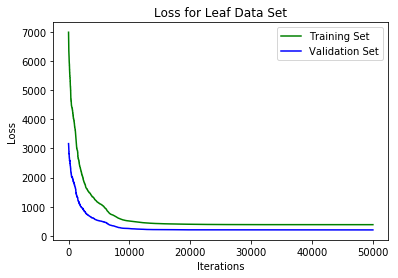

[660.43099568357388, 1297.5474889906329, 1809.3248830872137]
[333.79539210531851, 546.79511708681412, 797.5094914905543]


In [186]:
plt.plot(res1_f[3],'g',label='Training Set')
plt.plot(res1_f[4],'b',label='Validation Set')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss for Leaf Data Set')

plt.legend()
plt.show()
print(t_l_3)
print(v_l_3)

In [40]:
x = res1[0]

def nn_keras(x):
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]
    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))

    w1_all = []
    w1_all.append(w1)
    w1_all.append(b1)

    w2_all = []
    w2_all.append(w2)
    w2_all.append(b2)

    model = Sequential()
    model.add(Dense(15, input_dim=14, kernel_initializer='normal', activation='relu'))
    model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.layers[0].set_weights(w1_all)
    model.layers[1].set_weights(w2_all)
    out = model.predict(trainX)
    output = np.clip(out, 1e-15, 1. - 1e-15)
    er= -np.sum(trainY * np.log(output))
    predict_out = np.argmax(out,axis=1)+1
#     acc = 1-accuracy_score(testY_comp,predict_out)
#     print(acc)
    return er
    
